# Examen 2 - B: CNN Cáncer de Piel
### Hecho por: Joshua Sancho y Nicole Jara

## Descripción

CNN para clasificar entre 9 tipos de melanoma.

## Importar Librerías

In [91]:
import os
import random
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt 
from matplotlib.image import imread
import matplotlib.image as mpimg                        
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam            
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2      
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Carga del Dataset

In [53]:
train_dir = "../datasets/skin_cancer_divided/train"
test_dir = "../datasets/skin_cancer_divided/test"
val_dir = "../datasets/skin_cancer_divided/val"

In [182]:
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [183]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    batch_size=16,
    color_mode="rgb",
    class_mode="categorical"
)

validation_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128, 128),
    batch_size=16,
    color_mode="rgb",
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128, 128),
    batch_size=16,
    color_mode="rgb",
    class_mode="categorical"
)

Found 1646 images belonging to 9 classes.
Found 233 images belonging to 9 classes.
Found 478 images belonging to 9 classes.


## Visualización de los Datos

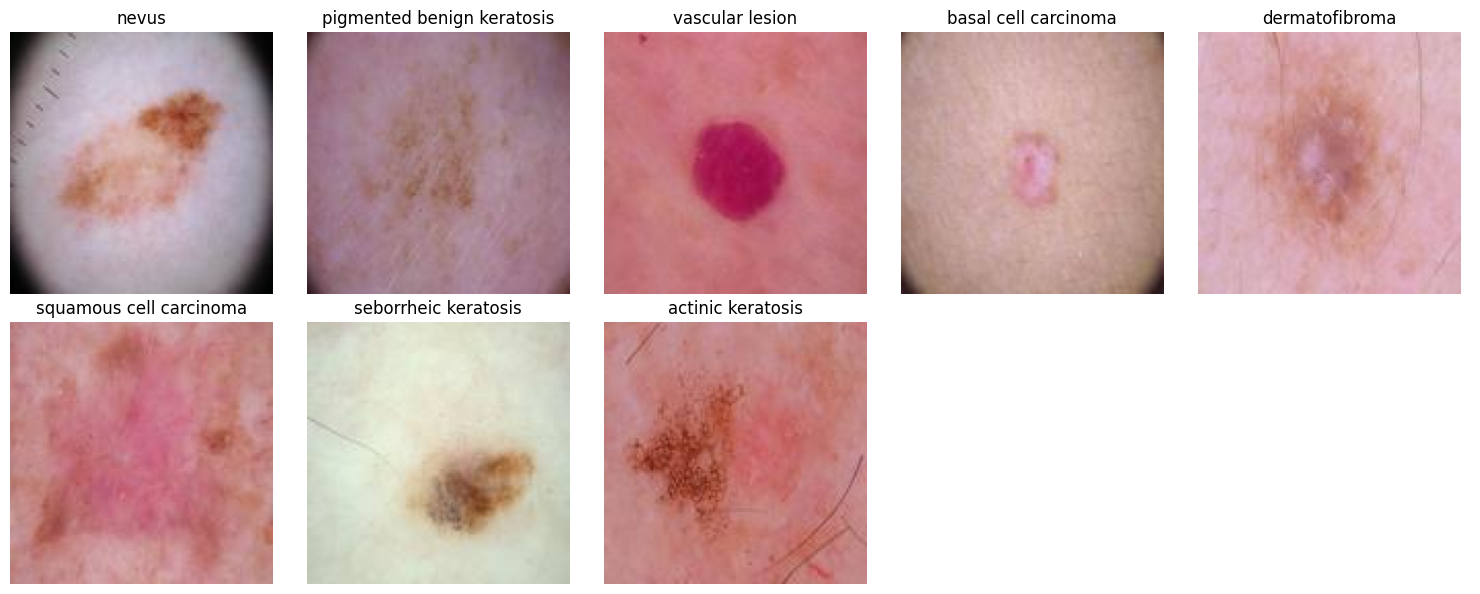

In [184]:
classes = os.listdir(train_dir)

random_classes = random.sample(classes, 8)

num_images_per_class = 1

num_cols = 5
num_rows = (len(random_classes) + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

for i, class_name in enumerate(random_classes):
    row = i // num_cols
    col = i % num_cols
    
    class_dir = os.path.join(train_dir, class_name)
    
    image_files = os.listdir(class_dir)
    
    random_image_file = random.choice(image_files)
    
    image_path = os.path.join(class_dir, random_image_file)
    img = imread(image_path)
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

for i in range(len(random_classes), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Entrenamiento del Modelo

In [208]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False

In [214]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(9, activation='softmax')(x)

In [215]:
model = Model(inputs=base_model.input, outputs=predictions)

In [216]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [217]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [218]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
103/103 [==============================] - 6s 43ms/step - loss: 1.8346 - accuracy: 0.3809 - val_loss: 6.7237 - val_accuracy: 0.2318 - lr: 0.0010
Epoch 2/100
103/103 [==============================] - 4s 43ms/step - loss: 1.3681 - accuracy: 0.5425 - val_loss: 1.9638 - val_accuracy: 0.3433 - lr: 0.0010
Epoch 3/100
103/103 [==============================] - 4s 42ms/step - loss: 1.3919 - accuracy: 0.5213 - val_loss: 17.7659 - val_accuracy: 0.0815 - lr: 0.0010
Epoch 4/100
103/103 [==============================] - 4s 41ms/step - loss: 1.3102 - accuracy: 0.5486 - val_loss: 2.2044 - val_accuracy: 0.3262 - lr: 0.0010
Epoch 5/100
103/103 [==============================] - 4s 43ms/step - loss: 1.2309 - accuracy: 0.5687 - val_loss: 5.9987 - val_accuracy: 0.1974 - lr: 0.0010
Epoch 6/100
103/103 [==============================] - 4s 43ms/step - loss: 1.1828 - accuracy: 0.6039 - val_loss: 3.4936 - val_accuracy: 0.2017 - lr: 0.0010
Epoch 7/100
103/103 [==============================] - 4s

In [219]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

29/29 [==============================] - 1s 17ms/step - loss: 1.1324 - accuracy: 0.6013


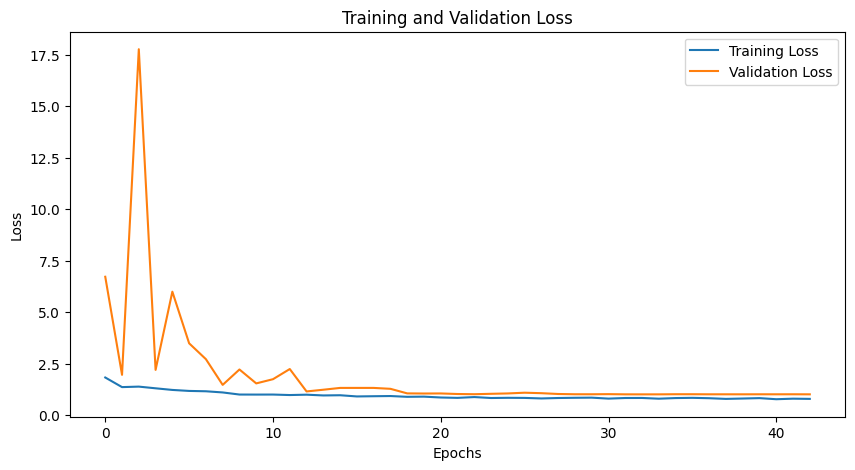

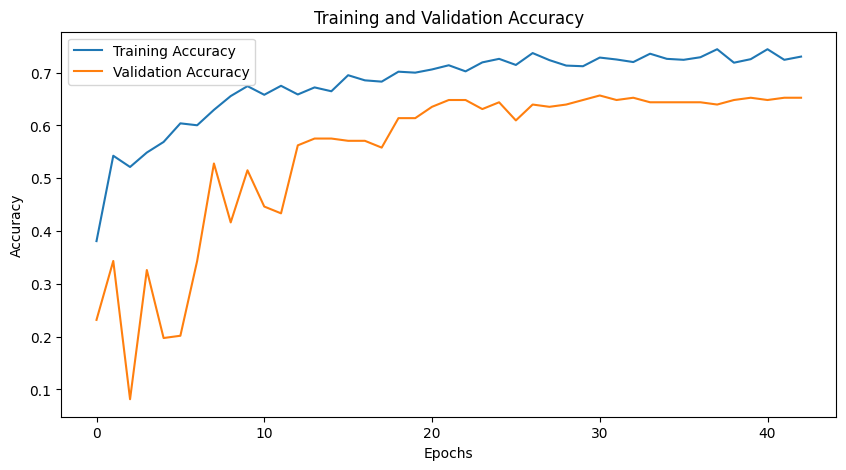

In [220]:
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluación

In [221]:
evaluation = model.evaluate(validation_generator)

print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

15/15 [==============================] - 0s 18ms/step - loss: 1.0159 - accuracy: 0.6524
Validation Loss: 1.0159074068069458
Validation Accuracy: 0.6523604989051819


## Conclusión

A pesar de que se intentó usar una red neuronal compleja con múltiples capas densas e incluso se hicieron pruebas ajustando el learning rate con regularizadores y el dropout, no se pudo aumentar el val accuracy por encima de 0.65, incluso utilizando transfer learning. Esto podría deberse al gran parecido que hay entre las categorías de las imágenes de melanomas en color y forma, lo que dificulta su precisión.